# top generator systematics


In [9]:
# imports and configuration
%cd /home/naodell/work/wbr/analysis

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.style.use('default')
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.systematic_tools as st
from scripts.template_maker import get_binning

np.set_printoptions(precision=3)
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':16,
          'ytick.labelsize':16,
         }
matplotlib.rcParams.update(params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 40185,
  "iopub_port": 58519,
  "stdin_port": 60273,
  "control_port": 53723,
  "hb_port": 38449,
  "ip": "127.0.0.1",
  "key": "ffe7e81b-9f75fbcb9a1c597a873e1d7d",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-738e4a57-4392-416f-8a00-7d794c000125.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [10]:
# Get the data 
selection = 'mumu'
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  ee    = 'lepton2_pt', 
                  emu   = 'trailing_lepton_pt', #'dilepton1_pt_asym', 
                  mutau = 'lepton2_pt', 
                  etau  = 'lepton2_pt', 
                  mu4j  = 'lepton1_pt',
                  e4j   = 'lepton1_pt'
                 )

input_dir = f'local_data/flatuples/test/{selection}_2016'
dataset_names = ['ttbar_inclusive', 'ttbar_lep', 'ttbar_semilep']
dm_nominal = pt.DataManager(input_dir, dataset_names, selection, scale=35.9e3)

input_dir = f'local_data/flatuples/ttbar_systematics_new/{selection}_2016'
dataset_names = [
                 'ttbar_inclusive_isrup', 'ttbar_inclusive_isrdown',    
                 'ttbar_inclusive_fsrup', 'ttbar_inclusive_fsrdown',    
                 'ttbar_inclusive_hdampup', 'ttbar_inclusive_hdampdown',
                 'ttbar_inclusive_tuneup', 'ttbar_inclusive_tunedown',
    
                 'ttbar_inclusive_isrup_ext2', 'ttbar_inclusive_isrdown_ext2',
                 'ttbar_inclusive_fsrup_ext1', 'ttbar_inclusive_fsrdown_ext1',    
                 'ttbar_inclusive_fsrup_ext2', 'ttbar_inclusive_fsrdown_ext2',    
                 'ttbar_inclusive_hdampup_ext1', 'ttbar_inclusive_hdampdown_ext1',
                 'ttbar_inclusive_tuneup_ext1', 'ttbar_inclusive_tunedown_ext1',
                ]
dm_syst_old = pt.DataManager(input_dir, dataset_names[:8], selection, scale=35.9e3, combine=False)
dm_syst_new = pt.DataManager(input_dir, dataset_names, selection, scale=35.9e3)

nominal total:  158113.7676439687


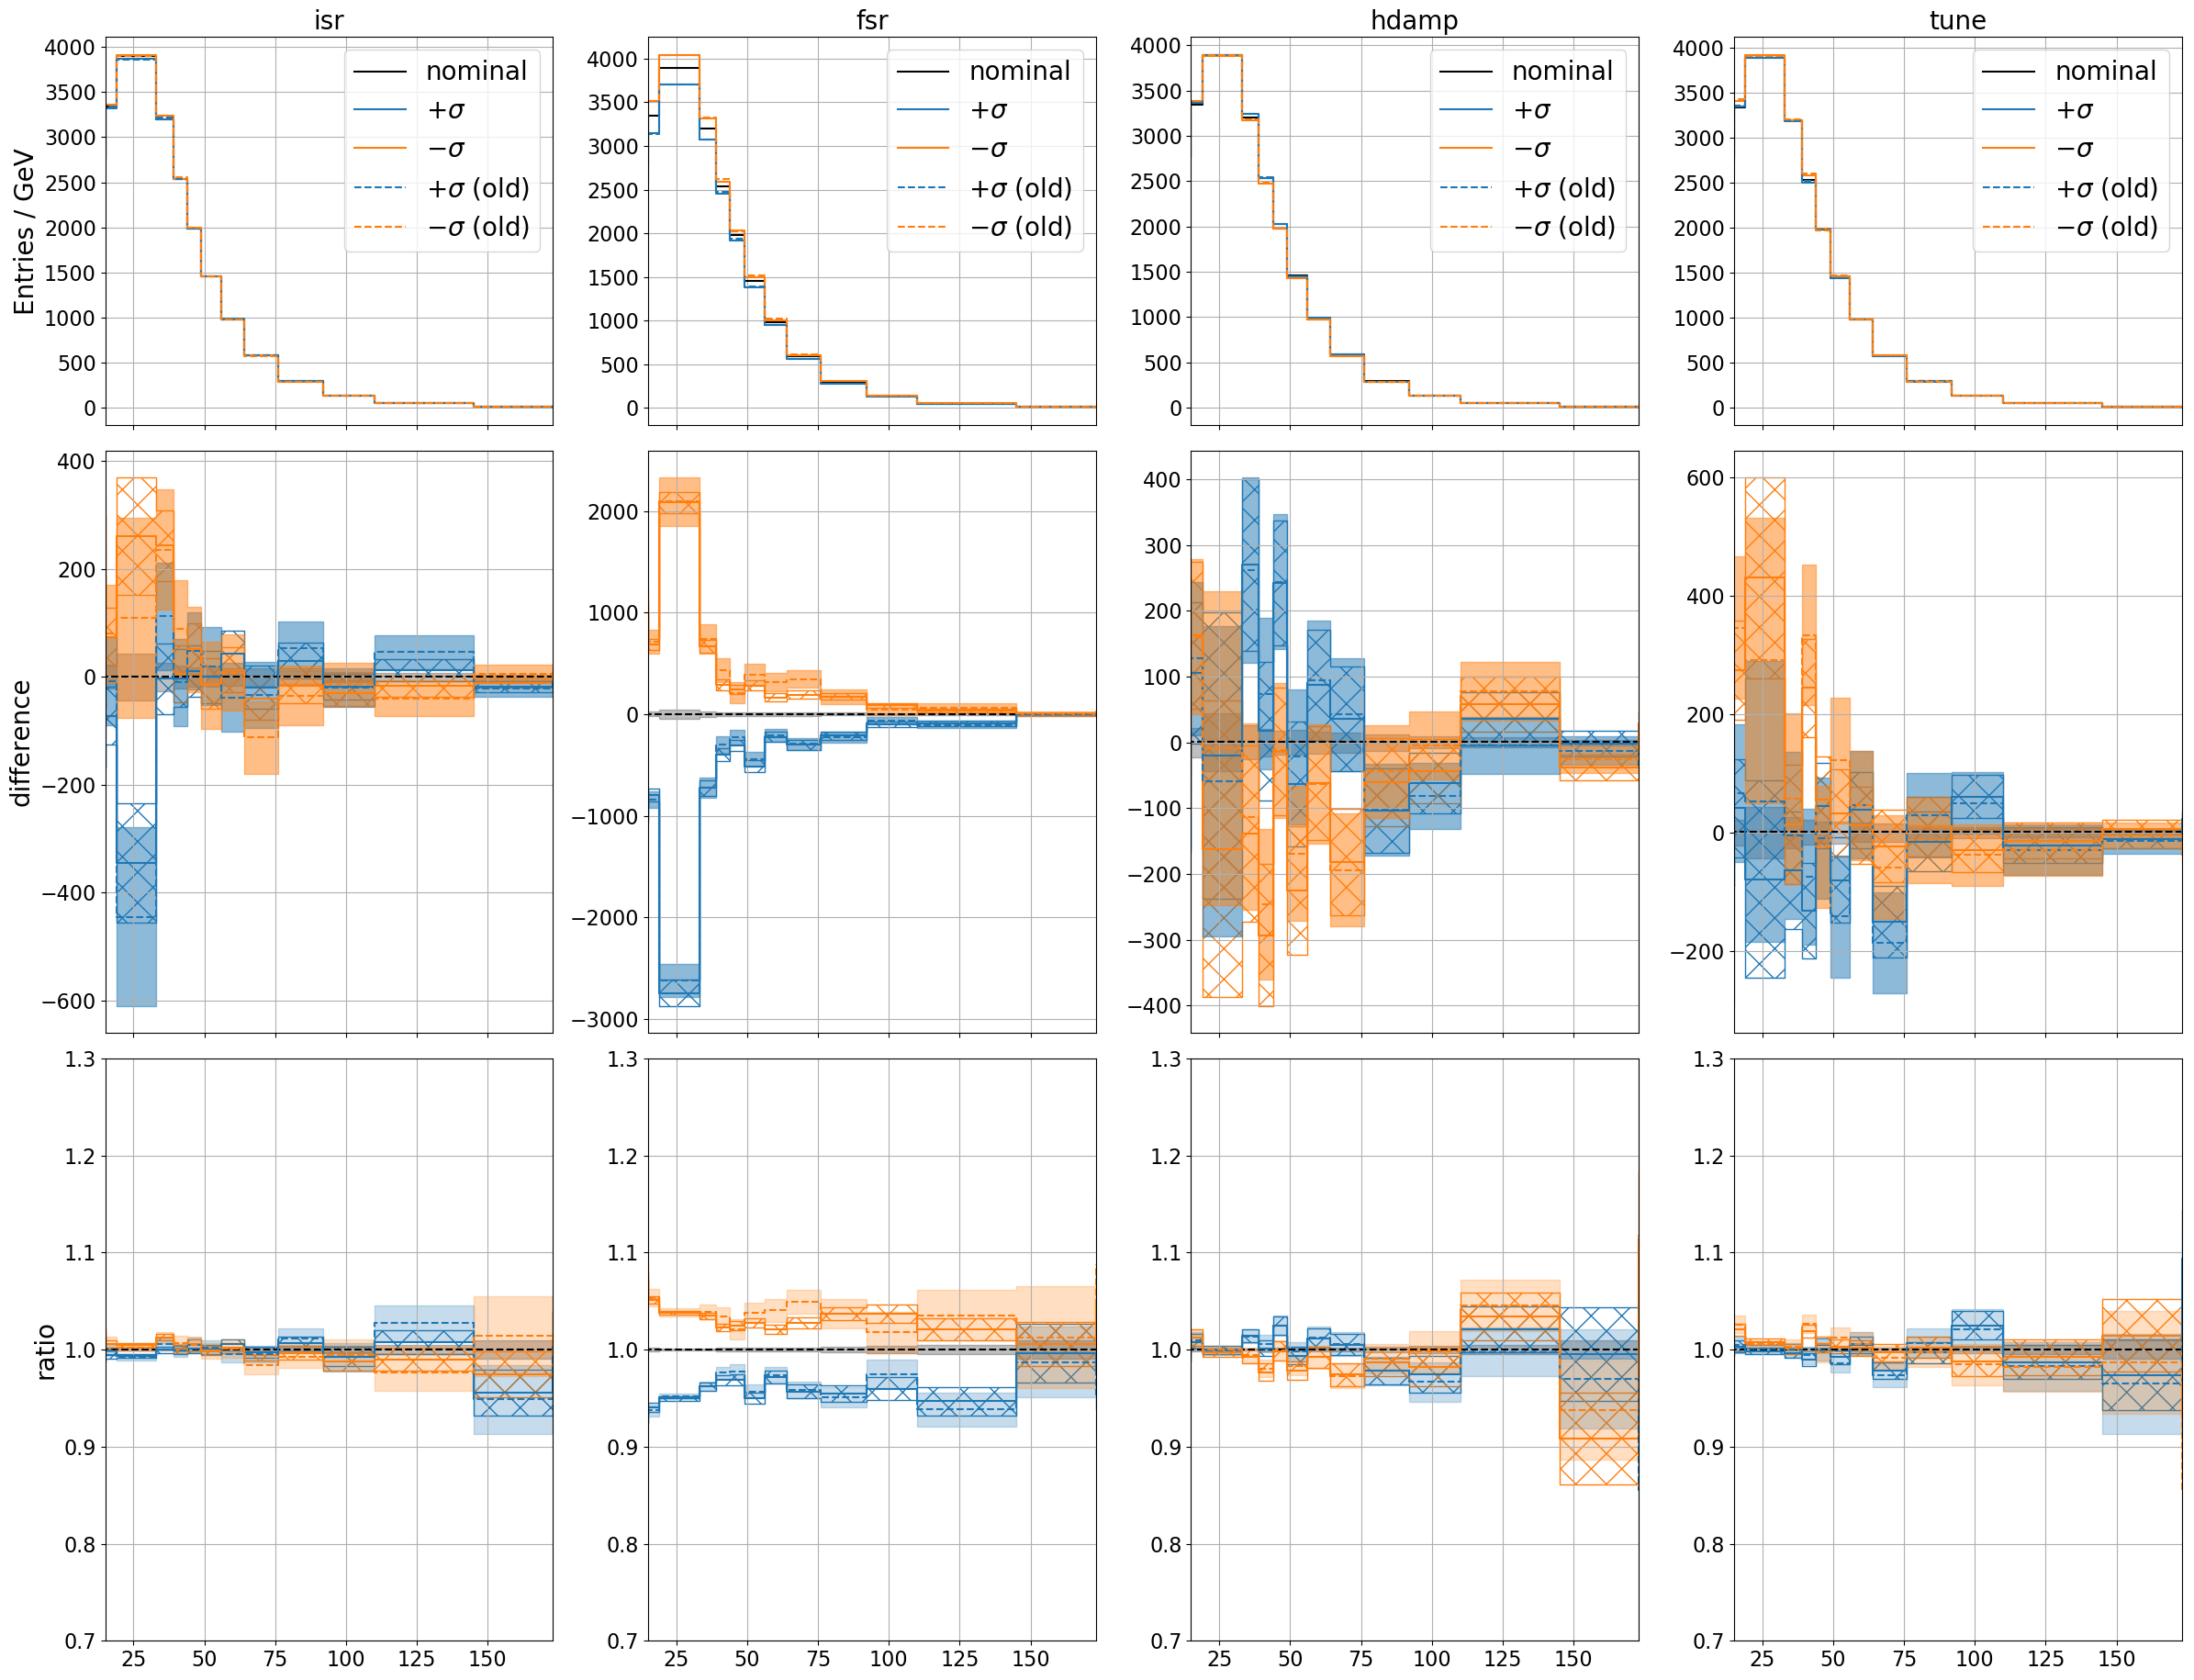

In [11]:
# Variations from dedicated samples

fig, axes = plt.subplots(3, 4, figsize=(24, 20), facecolor='white', sharey=False, sharex='col', gridspec_kw={'height_ratios':[2,3,3]})
fig.subplots_adjust(hspace=0)

feature = targets[selection]
df_nominal = dm_nominal.get_dataframe('ttbar')
_, bins = get_binning(df_nominal, feature)
dx = (bins[1:] - bins[:-1])
x = bins[:-1] #+ dx
for ix, label in enumerate(['isr', 'fsr', 'hdamp', 'tune']):
    
    df_up = dm_syst_new.get_dataframe(f'ttbar_{label}up')
    df_down = dm_syst_new.get_dataframe(f'ttbar_{label}down')
    df_up_old = dm_syst_old.get_dataframe(f'ttbar_inclusive_{label}up')
    df_down_old = dm_syst_old.get_dataframe(f'ttbar_inclusive_{label}down')
    
    if ix == 0:
        print('nominal total: ', df_nominal['weight'].sum())
    
    ax = axes[0][ix]
    h_nominal, _ = np.histogram(df_nominal[feature], bins=bins, weights=df_nominal.weight)
    ax.plot(x, h_nominal/dx, 'k', drawstyle='steps-post', label='nominal')
    
    h_up, _ = np.histogram(df_up[feature], bins=bins, weights=df_up.weight)
    ax.plot(x, h_up/dx, 'C0', drawstyle='steps-post', label=r'$+\sigma$')
    h_down, _ = np.histogram(df_down[feature], bins=bins, weights=df_down.weight)
    ax.plot(x, h_down/dx, 'C1', drawstyle='steps-post', label=r'$-\sigma$')
    
    h_up_old, _ = np.histogram(df_up_old[feature], bins=bins, weights=df_up_old.weight)
    ax.plot(x, h_up_old/dx, 'C0--', drawstyle='steps-post', label=r'$+\sigma$ (old)')
    h_down_old, _ = np.histogram(df_down_old[feature], bins=bins, weights=df_down_old.weight)
    ax.plot(x, h_down_old/dx, 'C1--', drawstyle='steps-post', label=r'$-\sigma$ (old)')
    
    if ix == 0:
        ax.set_ylabel('Entries / GeV')
        
    ax.set_title(f'{label}', fontsize=20)
    ax.set_xlim([bins[1], bins[-3]])
    ax.legend() 
    ax.grid()

    # calculate errors
    err_nominal, _ = np.histogram(df_nominal[feature], bins=bins, weights=df_nominal.weight**2)
    err_up, _ = np.histogram(df_up[feature], bins=bins, weights=df_up.weight**2)
    err_down, _ = np.histogram(df_down[feature], bins=bins, weights=df_down.weight**2)
    err_nominal, err_up, err_down = np.sqrt(err_nominal), np.sqrt(err_up), np.sqrt(err_down)
    
    err_up_old, _ = np.histogram(df_up_old[feature], bins=bins, weights=df_up_old.weight**2)
    err_down_old, _ = np.histogram(df_down_old[feature], bins=bins, weights=df_down_old.weight**2)
    err_up_old, err_down_old = np.sqrt(err_up_old), np.sqrt(err_down_old)
    
    #print(label)
    chi2_up = np.sum((h_up - h_nominal)**2/(err_up**2 + err_nominal**2))
    chi2_down = np.sum((h_down - h_nominal)**2/(err_down**2 + err_nominal**2))
    ratio_up = h_up/h_nominal
    ratio_down = h_down/h_nominal
    ratio_up_old = h_up_old/h_nominal
    ratio_down_old = h_down_old/h_nominal
    
    # ratio average smoothing
    #print(label)
    w_up, w_down = (err_up**2/h_nominal**2), (err_down**2/h_nominal**2)
    ratio_up_mean = np.sum((ratio_up/w_up))/np.sum(1/w_up)
    ratio_down_mean = np.sum((ratio_down/w_down))/np.sum(1/w_down)
    #print(np.sqrt(w_up), sep='\n')
    #print(np.sqrt(w_down), sep='\n')
    
    #print(np.sqrt(chi2_up)/bins.size)
    #print(np.sqrt(chi2_down)/bins.size)
    
    ax = axes[1][ix]
    y_up = h_up - h_nominal
    y_down = h_down - h_nominal
    y_up_old = h_up_old - h_nominal
    y_down_old = h_down_old - h_nominal
    
    ax.plot((bins[0], bins[-1]), [1, 1], 'k--')
    ax.plot(x, y_up, 'C0', drawstyle='steps-post')
    ax.plot(x, y_down, 'C1', drawstyle='steps-post')
    ax.plot(x, y_up_old, 'C0--', drawstyle='steps-post')
    ax.plot(x, y_down_old, 'C1--', drawstyle='steps-post')
    
    ax.fill_between(x, err_nominal, - err_nominal, color = 'k', alpha=0.25, step='post')
    #ax.fill_between(x, y_up + err_up, y_up - err_up, color = 'C0', alpha=0.5, step='post')
    #ax.fill_between(x, y_down + err_down, y_down - err_down, color = 'C1', alpha=0.5, step='post')
    ax.fill_between(x, y_up + err_up, y_up - err_up, edgecolor = 'C0', hatch='X', facecolor='none', step='post')
    ax.fill_between(x, y_down + err_down, y_down - err_down, edgecolor = 'C1', hatch='X', facecolor='none', step='post')
    ax.fill_between(x, y_up_old + err_up_old, y_up_old - err_up_old, color = 'C0', alpha=0.5, step='post')
    ax.fill_between(x, y_down_old + err_down_old, y_down_old - err_down_old, color = 'C1', alpha=0.5, step='post')
    
    ax.grid()
    if ix == 0:
         ax.set_ylabel('difference')
    #ax.set_ylim(0.8, 1.2)
    
    # symmetrization
    ratio_asymm = (1 - ratio_up_mean)/(1-ratio_down_mean)
    if ratio_asymm > -1/3: 
        mean_max = np.max([abs(1 - ratio_up_mean), abs(1 - ratio_down_mean)])
        #print(mean_max, ratio_up_mean, ratio_down_mean)
        if abs(1 - ratio_up_mean) >= abs(1 - ratio_down_mean):
            ratio_down_mean = 1 + (1 - ratio_up_mean)/3
            #print(ratio_down_mean)
        else:
            ratio_up_mean = 1 + (1 - ratio_down_mean)/3
            #print(ratio_up_mean)
            
    # smoothing
    #y_up_smooth = h_nominal*(ratio_up_mean - 1)
    #y_down_smooth = h_nominal*(ratio_down_mean - 1)
    #ax.plot(x+dx/2, y_up_smooth,'C0--', linewidth=3)
    #ax.plot(x+dx/2, y_down_smooth, 'C1--', linewidth=3)
    
    ax = axes[2][ix]
    y_up_old = h_up_old / h_nominal
    y_down_old = h_down_old / h_nominal
    
    ax.plot((bins[0], bins[-1]), [1, 1], 'k--')
    ax.plot(x, ratio_up, 'C0', drawstyle='steps-post')
    ax.plot(x, ratio_down, 'C1', drawstyle='steps-post')
    ax.plot(x, ratio_up_old, 'C0--', drawstyle='steps-post')
    ax.plot(x, ratio_down_old, 'C1--', drawstyle='steps-post')
    
    ax.fill_between(x, 1 + err_nominal/h_nominal, 1 - err_nominal/h_nominal, color = 'k', alpha=0.25, step='post')
    #ax.fill_between(x, ratio_up + err_up/h_nominal, ratio_up - err_up/h_nominal, edgecolor = 'C0', alpha=0.5, step='post')
    #ax.fill_between(x, ratio_down + err_down/h_nominal, ratio_down - err_down/h_nominal, edgecolor = 'C1', alpha=0.5, step='post')
    ax.fill_between(x, ratio_up + err_up/h_nominal, ratio_up - err_up/h_nominal, edgecolor = 'C0', hatch='X', facecolor='none', step='post')
    ax.fill_between(x, ratio_down + err_down/h_nominal, ratio_down - err_down/h_nominal, edgecolor = 'C1', hatch='X', facecolor='none', step='post')
    ax.fill_between(x, ratio_up_old + err_up_old/h_nominal, ratio_up_old - err_up_old/h_nominal, color = 'C0', alpha=0.25, step='post')
    ax.fill_between(x, ratio_down_old + err_down_old/h_nominal, ratio_down_old - err_down_old/h_nominal, color = 'C1', alpha=0.25, step='post')
    
    #ax.plot([x[0], x[-1]], [ratio_up_mean, ratio_up_mean],'C0--', linewidth=3)
    #ax.plot([x[0], x[-1]], [ratio_down_mean, ratio_down_mean],'C1--', linewidth=3)
    
    ax.grid()
    ax.set_ylim(0.7, 1.3)
    if ix == 0:
         ax.set_ylabel('ratio')

#fig.suptitle(f'{selection} channel', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'plots/systematics/ttbar_generator/{selection}_sources.pdf')
plt.show()

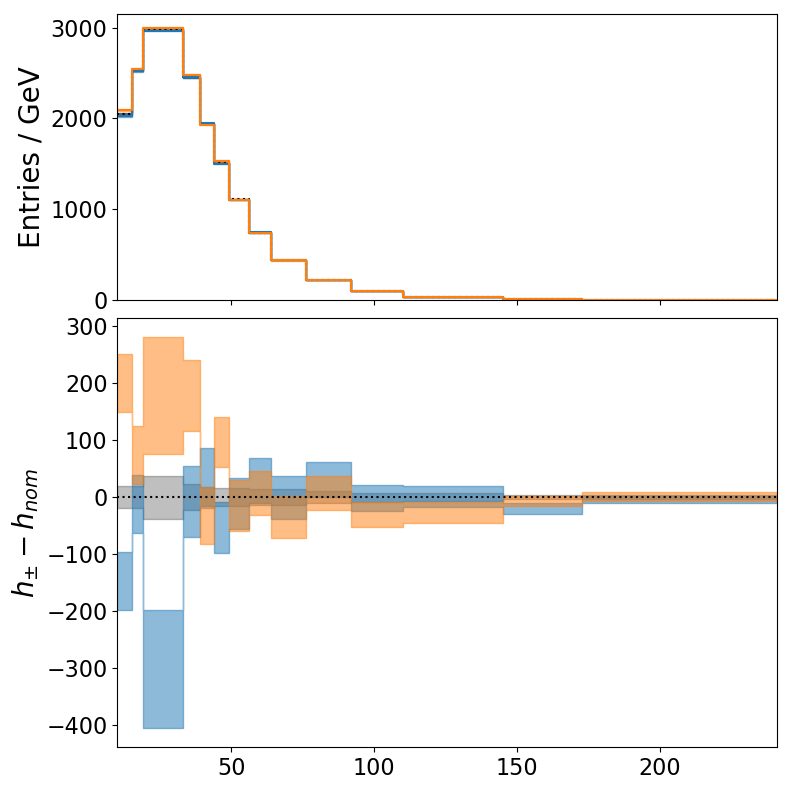

In [12]:
# test out template smoothing
fig, axes = plt.subplots(2, 1, figsize=(8, 8), facecolor='white', sharey=False, sharex='col', gridspec_kw={'height_ratios':[2,3]})

condition = 'n_jets >= 2 and n_bjets >= 1'
df_nominal = dm_nominal.get_dataframe('ttbar').query(condition)
df_up   = dm_syst_new.get_dataframe('ttbar_isrup').query(condition)
df_down = dm_syst_new.get_dataframe('ttbar_isrdown').query(condition)

ax = axes[0]
h_nom, _ = np.histogram(df_nominal[feature], bins, weights=df_nominal.weight)
var_nom, _ = np.histogram(df_nominal[feature], bins, weights=df_nominal.weight**2)
ax.plot(x, h_nom/dx, 'k:', drawstyle='steps-post')
ax.fill_between(x, (h_nom - np.sqrt(var_nom))/dx, (h_nom + np.sqrt(var_nom))/dx, color='k', alpha=0.5, step='post')

h_up, _ = np.histogram(df_up[feature], bins, weights=df_up.weight)
var_up, _ = np.histogram(df_up[feature], bins, weights=df_up.weight**2)
ax.plot(x, h_up/dx, 'C0-', drawstyle='steps-post')
ax.fill_between(x, (h_up - np.sqrt(var_up))/dx, (h_up + np.sqrt(var_up))/dx, color='C0', alpha=0.5, step='post')

h_down, _ = np.histogram(df_down[feature], bins, weights=df_down.weight)
var_down, _ = np.histogram(df_down[feature], bins, weights=df_down.weight**2)
ax.plot(x, h_down/dx, 'C1-', drawstyle='steps-post')
ax.fill_between(x, (h_down - np.sqrt(var_down))/dx, (h_down + np.sqrt(var_down))/dx, color='C1', alpha=0.5, step='post')

ax.set_xlim(bins[0], bins[-2])
ax.set_ylim(0, None)
ax.set_ylabel('Entries / GeV')

ax = axes[1]
ax.plot(x[[0, -1]], [0, 0], 'k:')
#ax.fill_between(x, np.sqrt(var_nom)/dx, -np.sqrt(var_nom)/dx, color='k', alpha=0.25, step='post')
ax.fill_between(x, np.sqrt(var_nom), -np.sqrt(var_nom), color='k', alpha=0.25, step='post')

dh_up = h_up - h_nom
derr_up = np.sqrt(var_nom + var_up)
ax.fill_between(x, (dh_up - derr_up),  (dh_up + derr_up), color='C0', alpha=0.5, step='post')

dh_down = h_down - h_nom
derr_down = np.sqrt(var_nom + var_down)
ax.fill_between(x, (dh_down - derr_down),  (dh_down + derr_down), color='C1', alpha=0.5, step='post')
#ax.set_ylim(-0.2, 0.2)
ax.set_ylabel(r'$h_{\pm} - h_{nom}$')

plt.tight_layout(h_pad=0.)
plt.show()